In [53]:
!pip install -U tensorflow-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 44.6 MB/s eta 0:00:00


In [54]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [55]:
import pandas as pd

df = pd.read_csv("/content/spam.csv")
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [56]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [57]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [58]:
df_spam = df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [59]:
df_ham = df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [60]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape


(747, 2)

In [61]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(1494, 2)

In [62]:
df_balanced['Category'].value_counts()

ham     747
spam    747
Name: Category, dtype: int64

In [63]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
2473,spam,Final Chance! Claim ur £150 worth of discount ...,1
1677,ham,"Yeah, that's fine! It's £6 to get in, is that ok?",0
4222,ham,Plz note: if anyone calling from a mobile Co. ...,0
5518,ham,"By the way, i've put a skip right outside the ...",0
4180,ham,Can ü send me a copy of da report?,0


In [65]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'], stratify=df_balanced['spam'])

In [66]:
X_train.head(4)

1456    Summers finally here! Fancy a chat or flirt wi...
2093    Oh, my love, it's soooo good to hear from you....
4998                         Esplanade lor. Where else...
3909    Sounds like a plan! Cardiff is still here and ...
Name: Message, dtype: object

In [67]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [68]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up",
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.84351724, -0.5132727 , -0.88845736, ..., -0.7474883 ,
        -0.75314754,  0.91964495],
       [-0.87208354, -0.50543964, -0.94446665, ..., -0.85847497,
        -0.71745336,  0.88082975]], dtype=float32)>

In [69]:
e = get_sentence_embeding([
    "banana",
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
)

In [70]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[1]])

array([[0.9911088]], dtype=float32)

In [71]:
cosine_similarity([e[0]],[e[3]])

array([[0.84703803]], dtype=float32)

In [72]:
cosine_similarity([e[3]],[e[4]])

array([[0.9872034]], dtype=float32)

In [73]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [74]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [75]:
len(X_train)

1120

In [76]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [77]:
model.fit(X_train, y_train, epochs=5)

Epoch 1/5
35/35 [==============================] - 32s 397ms/step - loss: 0.6168 - accuracy: 0.6741 - precision: 0.6696 - recall: 0.6875
Epoch 2/5
35/35 [==============================] - 14s 392ms/step - loss: 0.5166 - accuracy: 0.7982 - precision: 0.7961 - recall: 0.8018
Epoch 3/5
35/35 [==============================] - 15s 423ms/step - loss: 0.4564 - accuracy: 0.8429 - precision: 0.8179 - recall: 0.8821
Epoch 4/5
35/35 [==============================] - 13s 365ms/step - loss: 0.4070 - accuracy: 0.8687 - precision: 0.8629 - recall: 0.8768
Epoch 5/5
35/35 [==============================] - 13s 368ms/step - loss: 0.3752 - accuracy: 0.8839 - precision: 0.8620 - recall: 0.9143


In [78]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 5s 337ms/step - loss: 0.3347 - accuracy: 0.8824 - precision: 0.8824 - recall: 0.8824


[0.3346996307373047,
 0.8823529481887817,
 0.8823529481887817,
 0.8823529481887817]

In [79]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten(

)

12/12 [==============================] - 5s 390ms/step


In [80]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted


array([0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0,

In [81]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[165,  22],
       [ 22, 165]])

Text(50.722222222222214, 0.5, 'Truth')

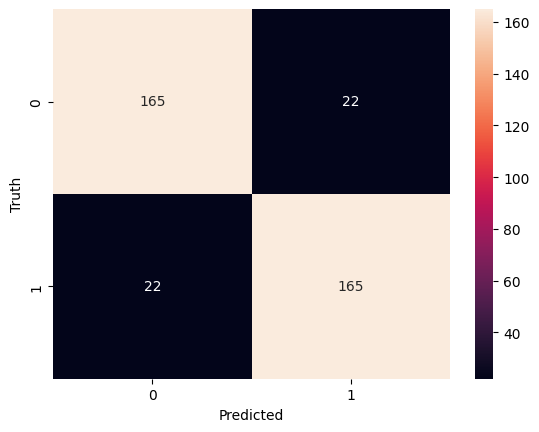

In [82]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [83]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       187
           1       0.88      0.88      0.88       187

    accuracy                           0.88       374
   macro avg       0.88      0.88      0.88       374
weighted avg       0.88      0.88      0.88       374

